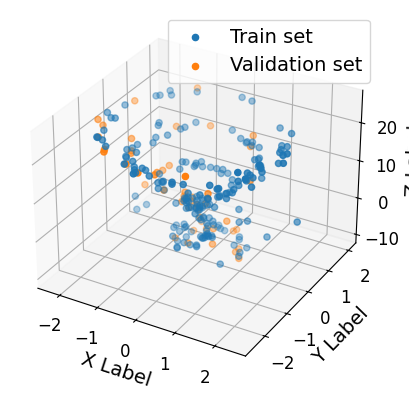

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, learning_curve
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
# from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb

plt.rcParams.update({
    'font.size': 14,          # Dimensione globale del testo
    'axes.titlesize': 18,     # Titolo degli assi
    'axes.labelsize': 14,     # Etichette degli assi
    'xtick.labelsize': 12,    # Etichette dei tick sull'asse x
    'ytick.labelsize': 12,    # Etichette dei tick sull'asse y
    'legend.fontsize': 14,    # Font delle leggende
    'figure.titlesize': 20    # Titolo generale della figura
})

import numpy as np

def mee(y_true, y_pred):
    """
    Calcola la distanza media (MEE) tra i punti reali e quelli predetti.

    Parameters:
        y_true (numpy array): Array di forma (n, 3) contenente i punti reali.
        y_pred (numpy array): Array di forma (n, 3) contenente i punti predetti.

    Returns:
        float: La distanza media.
    """
    distances = np.sqrt(np.sum((y_true - y_pred) ** 2, axis=1))     # Calcola la distanza euclidea per ciascun punto

    return np.mean(distances)     # Restituisce la media delle distanze

# Esempio di utilizzo
# y_true = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# y_pred = np.array([[1.1, 2.1, 3.1], [3.9, 4.8, 5.9], [6.8, 7.9, 9.1]])

# mee_value = mee(y_true, y_pred)
# print(f"Mean Euclidean Error: {mee_value}")


meeScorer = make_scorer(mee, greater_is_better=False)
mse = make_scorer(mean_squared_error, greater_is_better=False)

path = "C:\\Users\\giuse\\Downloads\\ML-CUP24-"
train = pd.read_csv(path + "TR.csv", header=7)
test = pd.read_csv(path + "TS.csv", header=7)

columns = ["id", "x1", "x2", "x3", "x4", "x5", "x6", "x7",
           "x8", "x9", "x10", "x11", "x12", "y1", "y2", "y3"]
elemento = train.columns.str.split()
elemento = elemento.map(lambda x: [float(i) for i in x])
c = np.zeros(len(elemento))

for a in range(len(elemento)):
    b = elemento[a]
    c[a] = b[0]

elemento = c

train.columns = columns
train.loc[len(train)] = elemento

elemento = test.columns.str.split()
elemento = elemento.map(lambda x: [float(i) for i in x])
c = np.zeros(len(elemento))

for a in range(len(elemento)):
    b = elemento[a]
    c[a] = b[0]

elemento = c

test.columns = columns[:13]
test.loc[len(test)] = elemento

train = train.drop(columns=["id"])
test = test.drop(columns=["id"])

trainLabel = train[["y1", "y2", "y3"]]
train = train.drop(columns=["y1", "y2", "y3"])

train, val, trainLabel, valLabel = train_test_split(train, trainLabel, test_size=0.2, random_state=42)
kf = KFold(n_splits=5, random_state=42, shuffle=True)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(trainLabel['y1'], trainLabel['y2'], trainLabel['y3'], label='Train set')
ax.scatter(valLabel['y1'], valLabel['y2'], valLabel['y3'], label='Validation set')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()
plt.show()


MEE: 0.9304268197338121, {'estimator__fit_intercept': False}


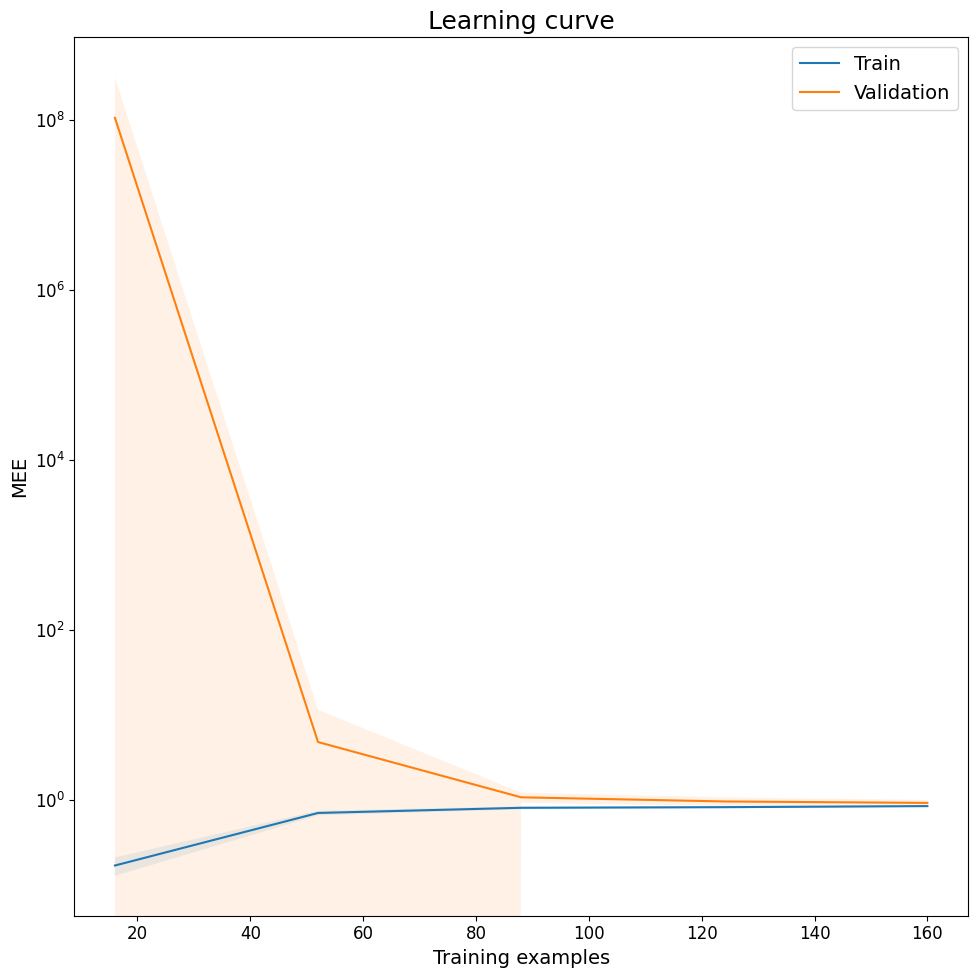

Validation MEE: 0.9603863314851709
Validation MSE: 0.39816346739970276


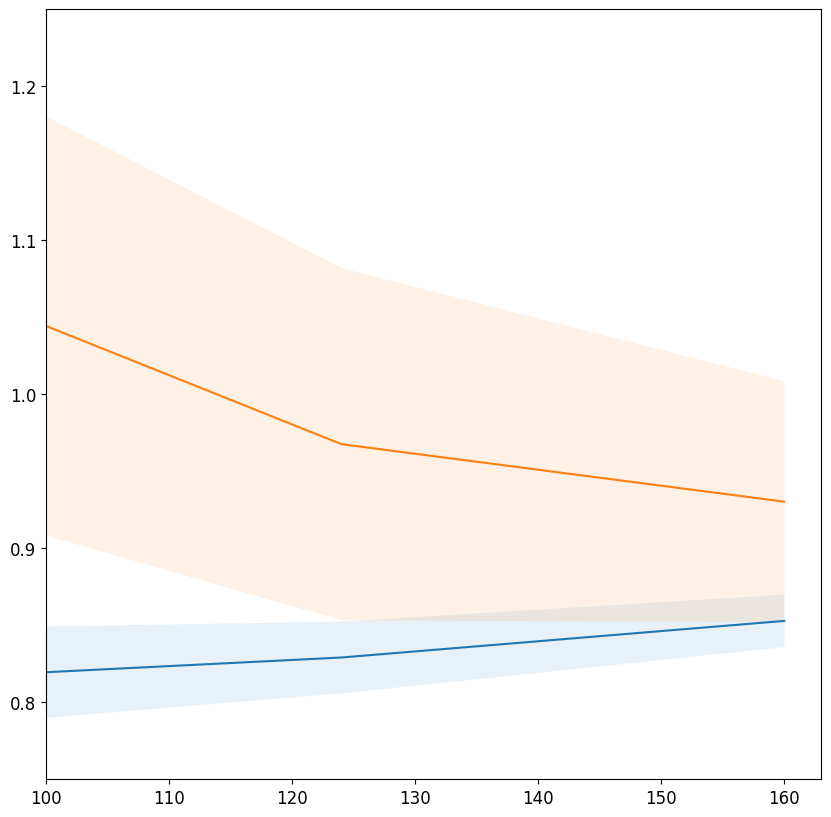

In [112]:
linReg = MultiOutputRegressor(LinearRegression())
parameters = { "estimator__fit_intercept": [True, False],}
linReg = GridSearchCV(linReg, parameters, cv=kf, scoring=meeScorer, n_jobs=-1)
linReg.fit(train, trainLabel)
# trainScores = cross_val_score(linReg, train, trainLabel, cv=kf, scoring=meeScorer, n_jobs=-1)
# print(f"MEE: {-trainScores}, {-trainScores.mean():.2f}, {trainScores.std():.2f}")
print(f'MEE: {-linReg.best_score_}, {linReg.best_params_}')

train_sizes, train_scores, val_scores = learning_curve(linReg, train, trainLabel, cv=kf, scoring=meeScorer, n_jobs=-1)
train_scores = -train_scores
val_scores = -val_scores
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 10))
plt.plot(train_sizes, train_mean, label="Train")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label="Validation")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.yscale("log")
plt.xlabel("Training examples")
plt.ylabel("MEE")
plt.title("Learning curve")
plt.legend()
plt.tight_layout()
plt.show()

valPred = linReg.predict(val)
valMEE = mee(valLabel.values, valPred)
print(f"Validation MEE: {valMEE}")
valMSE = mean_squared_error(valLabel.values, valPred)
print(f"Validation MSE: {valMSE}")

# valPredLRFrame = pd.DataFrame(valPred, columns=["y1", "y2", "y3"])
# valPredLRFrame.to_csv("valPredLR.csv", index=False)

plt.figure(figsize=(10, 10))
plt.plot(train_sizes, train_mean, label="Train")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label="Validation")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
# plt.yscale("log")
plt.ylim(0.75, 1.25)
plt.xlim(100, 163)
# plt.xlabel("Training examples")
# plt.ylabel("MEE")
# plt.title("Learning curve")
# plt.legend()
plt.show()

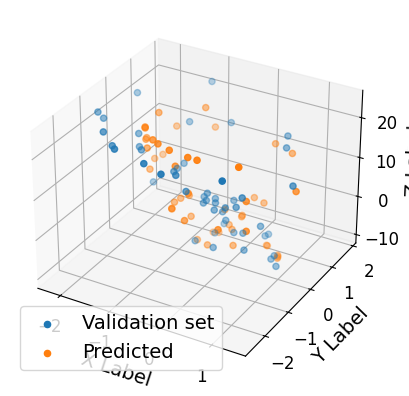

In [94]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valLabel['y1'], valLabel['y2'], valLabel['y3'], label='Validation set')
ax.scatter(valPred[:, 0], valPred[:, 1], valPred[:, 2], label='Predicted')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()
plt.show()

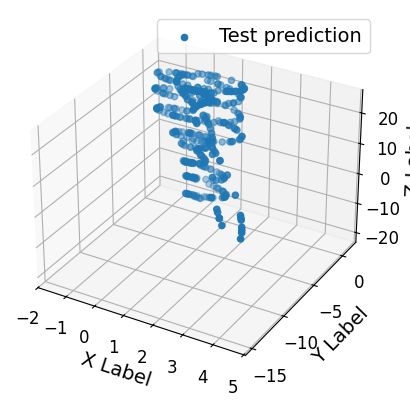

In [102]:
PRED = linReg.predict(test)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(valLabel['y1'], valLabel['y2'], valLabel['y3'], label='Validation set')
ax.scatter(PRED[:, 0], PRED[:, 1], PRED[:, 2], label='Test prediction')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()
plt.show()

PRED = pd.DataFrame(PRED, columns=["y1", "y2", "y3"])
PRED.to_csv('provaLR.csv', index=False)

In [96]:
rf = RandomForestRegressor(random_state=42)
parameters = {
    "n_estimators": [10, 20, 50],
    "max_depth": [3, 5],
    'max_features': ['sqrt', 'log2', None],
    'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
}
GridRandomFR = GridSearchCV(rf, parameters, cv=kf, scoring=meeScorer, n_jobs=-1)
GridRandomFR.fit(train, trainLabel)
print("Random Forest GridSearch: ", -GridRandomFR.best_score_, GridRandomFR.best_params_)

train_sizes, train_scores, val_scores = learning_curve(GridRandomFR, train, trainLabel, cv=kf, scoring=meeScorer, n_jobs=-1)
train_scores = -train_scores
val_scores = -val_scores
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

C:\Users\giuse\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\giuse\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\giuse\AppData\Roaming\Python\Python313\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\giuse\AppData\Roaming\Python\Python313\site-

Random Forest GridSearch:  0.8958350500500452 {'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None, 'n_estimators': 20}


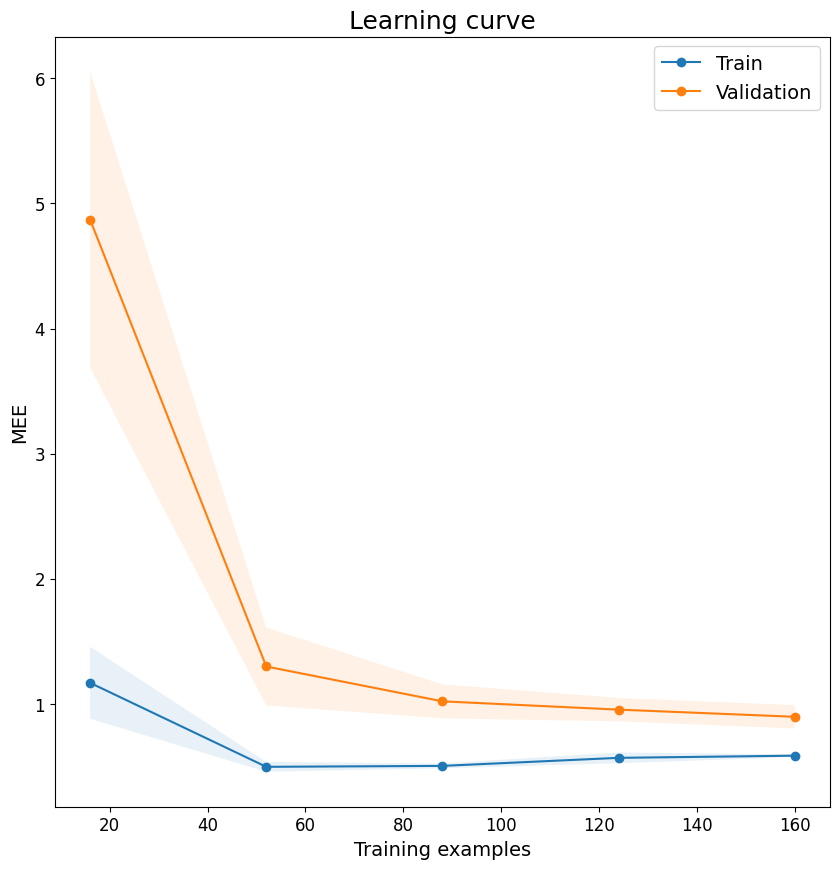

Validation MEE: 0.9337116607756819
Validation MSE: 0.39310709347988193


In [101]:
plt.figure(figsize=(10, 10))
plt.plot(train_sizes, train_mean, label="Train", marker="o")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label="Validation", marker="o")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
# plt.yscale("log")
plt.xlabel("Training examples")
plt.ylabel("MEE")
plt.title("Learning curve")
plt.legend()
plt.show()

valPred = GridRandomFR.predict(val)
valMEERF = mee(valLabel.values, valPred)
print(f"Validation MEE: {valMEERF}")
valMSERF = mean_squared_error(valLabel.values, valPred)
print(f"Validation MSE: {valMSERF}")

valPredFRFrame = pd.DataFrame(valPred, columns=["y1", "y2", "y3"])
valPredFRFrame.to_csv("valPredFR.csv", index=False)

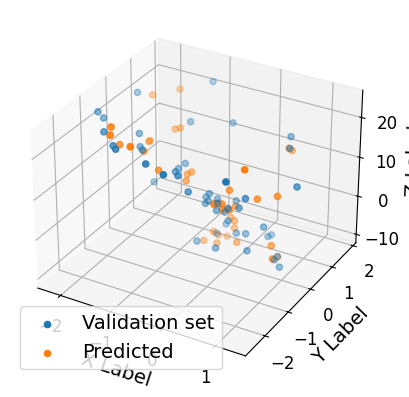

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valLabel['y1'], valLabel['y2'], valLabel['y3'], label='Validation set')
ax.scatter(valPred[:, 0], valPred[:, 1], valPred[:, 2], label='Predicted')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()
plt.show()

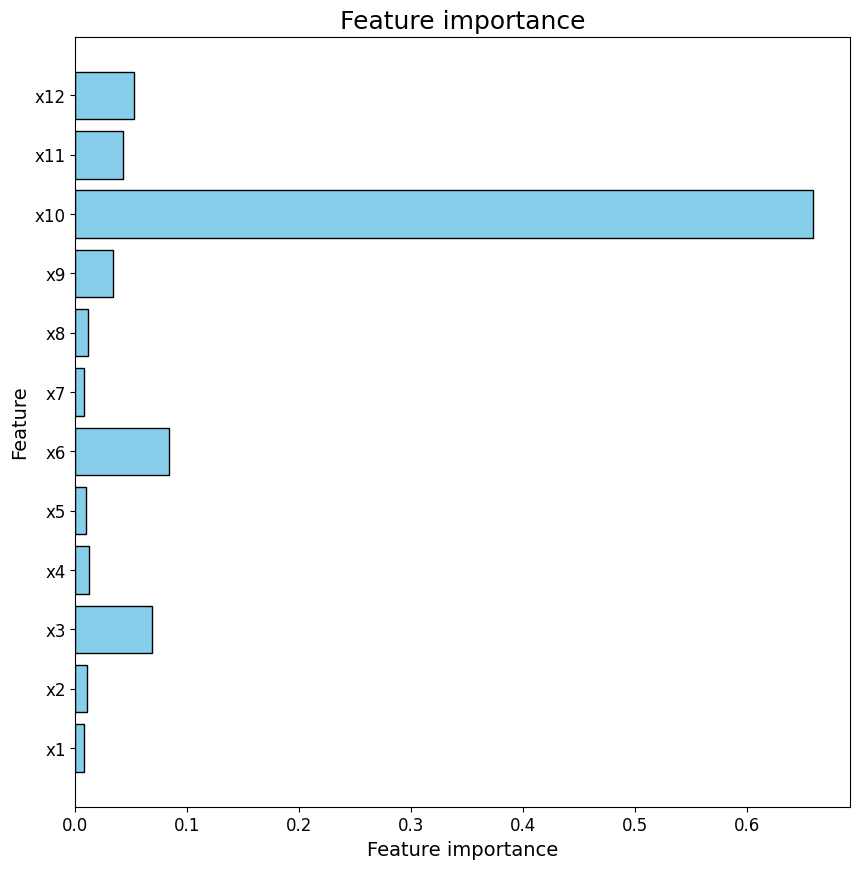

In [105]:
feature_importances = GridRandomFR.best_estimator_.feature_importances_

plt.figure(figsize=(10, 10))
plt.barh(train.columns, feature_importances, color="skyblue", edgecolor="black")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Feature importance")
plt.show()

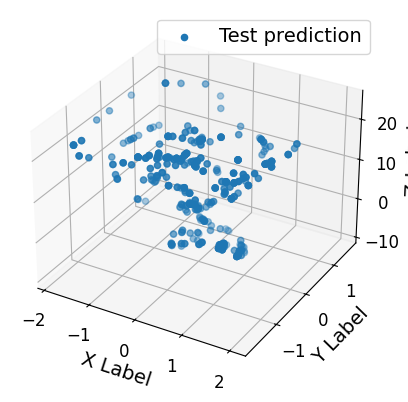

In [100]:
PRED = GridRandomFR.predict(test)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(valLabel['y1'], valLabel['y2'], valLabel['y3'], label='Validation set')
ax.scatter(PRED[:, 0], PRED[:, 1], PRED[:, 2], label='Test prediction')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.legend()
plt.show()

PREDFrame = pd.DataFrame(PRED, columns=["y1", "y2", "y3"], index=None)
PREDFrame.to_csv('prova.csv', index=False)

In [73]:
NeuralNet = MLPRegressor(random_state=42)
parameters = {
              'hidden_layer_sizes': [(100), (100, 100)],
              'solver': ["adam", "lbfgs", "sgd"],
              'activation': ["logistic", "tanh", "relu"],
              'max_iter': [1000, 2000]
              }
NeuralNet = GridSearchCV(NeuralNet, parameters, n_jobs=-1, cv=kf, scoring=meeScorer)

NeuralNet = NeuralNet.fit(train, trainLabel)
print(NeuralNet.best_params_, NeuralNet.best_score_)

c:\Program Files\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'activation': 'relu', 'hidden_layer_sizes': (100, 100), 'max_iter': 1000, 'solver': 'sgd'} -0.8205627239385164


In [74]:
train_sizes, train_scores, val_scores = learning_curve(NeuralNet, train, trainLabel, cv=kf, scoring=meeScorer, n_jobs=-1)
train_scores = -train_scores
val_scores = -val_scores
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 10))
plt.plot(train_sizes, train_mean, label="Train")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label="Validation")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.yscale("log")
plt.xlabel("Training examples")
plt.ylabel("MEE")
plt.title("Learning curve")
plt.legend()
plt.show()

valPred = NeuralNet.predict(val)
valMEENN = mee(valLabel.values, valPred)
print(f"Validation MEE: {valMEENN}")
valMSENN = mean_squared_error(valLabel.values, valPred)
print(f"Validation MSE: {valMSENN}")

KeyboardInterrupt: 

In [26]:
GradientB = MultiOutputRegressor(GradientBoostingRegressor())
parameters = {
              'n_estimators': [100, 500, 1000],
              'max_depth': [3, 5, 10],
              'learning_rate': [0.001, 0.01, 0.1]
              }
# GradientB = GridSearchCV(GradientB, parameters, n_jobs=nJobs)
GradientB.fit(train, trainLabel)
GradientBCross_mse = cross_val_score(GradientB, train, trainLabel, cv=10, scoring=mse)
print("Gradient Boosting: ", GradientBCross_mse.mean())

GradientBPred = pd.DataFrame(GradientB.predict(test))
GradientBPred.to_csv("predGradientB.csv", index=False, header=False)


Gradient Boosting:  0.36476354768871383


In [27]:
ada = MultiOutputRegressor(AdaBoostRegressor())
parameters = {
              'n_estimators': [50, 100, 500],
              'learning_rate': [0.001, 0.01, 0.1]
              }
# ada = GridSearchCV(ada, parameters, n_jobs=nJobs)
ada.fit(train, trainLabel)
adaCross_mse = cross_val_score(ada, train, trainLabel, cv=10, scoring=mse)
print("Ada Boost: ", adaCross_mse.mean())

adaPred = pd.DataFrame(ada.predict(test))
adaPred.to_csv("predAda.csv", index=False, header=False)


Ada Boost:  0.4267647099366504


In [ ]:
# xgBR = XGBRegressor(n_estimators=100, max_depth=10)
# xgBR.fit(train, trainLabel)
# xgBRCross_mse = cross_val_score(xgBR, train, trainLabel, cv=10, scoring=mse)
# print("XGBoost: ", xgBRCross_mse.mean())

# xgb.fit()

In [ ]:
# modello = MultiOutputRegressor(lgb.LGBMRegressor())
# modello.fit(train, trainLabel)
# lgbCross_mse = cross_val_score(modello, train, trainLabel, cv=10, scoring=mse)
# print("LightGBM: ", lgbCross_mse.mean())

# params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30]
# }
# lbgMod = lgb.cv(params=params, train_set=train, num_boost_round=100, nfold=10, metrics='mse')